 # Individual Experimentation
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
#### Import Modules

In [221]:
import pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from functools import lru_cache
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [222]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_WORD = 150

BATCH_SIZE = 128
EPOCHS = 5

# Data Preparation

#### Read in the dataset
The dataset can be download here (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) <br>
The dataset comes in 3 csv files, the training dataset, the test comments and the test labels

In [223]:
# Read in training dataset
train = pd.read_csv(TRAIN_DATASET)

# Read in test data and labels
test_data = pd.read_csv(TEST_DATA)
test_labels = pd.read_csv(TEST_LABELS)

# Combine test data and labels into one data frame
test = pd.concat([test_data, test_labels], axis=1)

# Remove redundant id field from both datasets
train = train.drop(columns=REDUNDANT_FIELDS)
test = test.drop(columns=REDUNDANT_FIELDS)

# Remove samples with labels containing -1 in test dataset, this 
# is a place holder for samples that were not assigned labels.
test = test.drop(test[(test.toxic == -1) |
                      (test.severe_toxic == -1) |
                      (test.obscene == -1) |
                      (test.threat == -1) |
                      (test.insult == -1) |
                      (test.identity_hate == -1)].index)

#### Visualise the initial class balance for train dataset

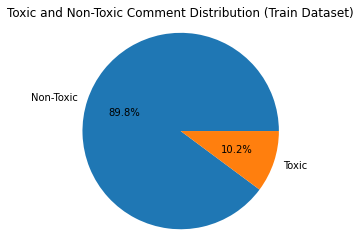

In [226]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution (Train Dataset)')
plt.axis('equal')
plt.show()

In [227]:
classes = {}

for index in range(1,7):
    classes.update({train.iloc[:,index].name : np.histogram(train.iloc[:,index], bins=2)[0]})

classes

{'toxic': array([144277,  15294], dtype=int64),
 'severe_toxic': array([157976,   1595], dtype=int64),
 'obscene': array([151122,   8449], dtype=int64),
 'threat': array([159093,    478], dtype=int64),
 'insult': array([151694,   7877], dtype=int64),
 'identity_hate': array([158166,   1405], dtype=int64)}

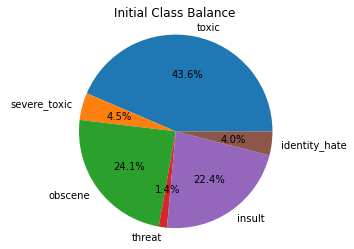

In [228]:
labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Class Balance')
plt.axis('equal')
plt.show()

#### Visualise the initial class balance for test dataset

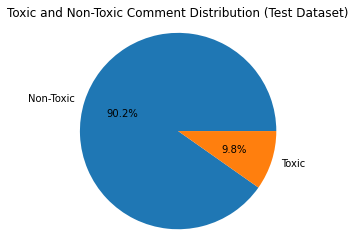

In [229]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = test[(test.toxic == 0) &
                  (test.severe_toxic == 0) & 
                  (test.obscene == 0) & 
                  (test.threat == 0) & 
                  (test.insult == 0) & 
                  (test.identity_hate == 0)]

# Gather all samples that are labelled
toxic = test[(test.toxic == 1) |
                  (test.severe_toxic == 1) | 
                  (test.obscene == 1) | 
                  (test.threat == 1) | 
                  (test.insult == 1) | 
                  (test.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution (Test Dataset)')
plt.axis('equal')
plt.show()

In [230]:
classes = {}

for index in range(1,7):
    classes.update({test.iloc[:,index].name : np.histogram(test.iloc[:,index], bins=2)[0]})

classes

{'toxic': array([57888,  6090], dtype=int64),
 'severe_toxic': array([63611,   367], dtype=int64),
 'obscene': array([60287,  3691], dtype=int64),
 'threat': array([63767,   211], dtype=int64),
 'insult': array([60551,  3427], dtype=int64),
 'identity_hate': array([63266,   712], dtype=int64)}

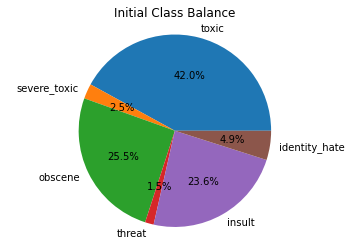

In [231]:
labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Class Balance')
plt.axis('equal')
plt.show()

#### Balance the classes
From the visuals it is clear that the number of non-toxic samples (89.8%) greatly outweigh comments that are toxic in any way (10.2%). A large amount of non-toxic comments need to be dropped to address this.

There is also an imbalance between the different toxic labels. The "toxic" label is the most present (with 43.6%), which is expected as comments that are obscene, insulting, attack identity or a threat can also be seen as toxic. There are very few examples of comments with the labels "severe_toxic", "identity_hate" or "threat" (4.5%, 4.0% and 1.4% respectively), meaning samples from the other labels should be dropped to balance the classes.

A similar initial class distribution can be observed for the test dataset

In [233]:
# Drop toxic samples
balanced_train = train.drop(train[(train.toxic == 1) & 
                          (train.severe_toxic != 1) & 
                          (train.threat != 1) & 
                          (train.obscene != 1) &
                          (train.insult != 1) &
                          (train.identity_hate != 1)].index[:3000])

# Drop obscene samples
balanced_train = balanced_train.drop(balanced_train[(balanced_train.toxic == 1) & 
                          (balanced_train.severe_toxic != 1) & 
                          (balanced_train.threat != 1) & 
                          (balanced_train.obscene == 1) &
                          (balanced_train.insult != 1) &
                          (balanced_train.identity_hate != 1)].index[:3000])

# Drop insult samples
balanced_train = balanced_train.drop(balanced_train[(balanced_train.toxic == 1) & 
                          (balanced_train.severe_toxic != 1) & 
                          (balanced_train.threat != 1) & 
                          (balanced_train.obscene != 1) &
                          (balanced_train.insult == 1) &
                          (balanced_train.identity_hate != 1)].index[:3000])

# Drop non-toxic samples
balanced_train = balanced_train.drop(balanced_train[(balanced_train.toxic != 1) & 
                          (balanced_train.severe_toxic != 1) & 
                          (balanced_train.threat != 1) & 
                          (balanced_train.obscene != 1) &
                          (balanced_train.insult != 1) &
                          (balanced_train.identity_hate != 1)].index[:75000])


In [251]:
# Drop toxic samples
balanced_test = test.drop(test[(test.toxic == 1) & 
                          (test.severe_toxic != 1) & 
                          (test.threat != 1) & 
                          (test.obscene != 1) &
                          (test.insult != 1) &
                          (test.identity_hate != 1)].index[:3000])

# Drop obscene samples
balanced_test = balanced_test.drop(balanced_test[(balanced_test.toxic == 1) & 
                          (balanced_test.severe_toxic != 1) & 
                          (balanced_test.threat != 1) & 
                          (balanced_test.obscene == 1) &
                          (balanced_test.insult != 1) &
                          (balanced_test.identity_hate != 1)].index[:3000])

# Drop insult samples
balanced_test = balanced_test.drop(balanced_test[(balanced_test.toxic == 1) & 
                          (balanced_test.severe_toxic != 1) & 
                          (balanced_test.threat != 1) & 
                          (balanced_test.obscene != 1) &
                          (balanced_test.insult == 1) &
                          (balanced_test.identity_hate != 1)].index[:3000])

# Drop non-toxic samples
balanced_test = balanced_test.drop(balanced_test[(balanced_test.toxic != 1) & 
                          (balanced_test.severe_toxic != 1) & 
                          (balanced_test.threat != 1) & 
                          (balanced_test.obscene != 1) &
                          (balanced_test.insult != 1) &
                          (balanced_test.identity_hate != 1)].index[:50000])

#### Visualise the new class balance for train dataset

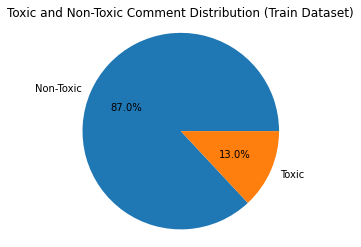

In [239]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = balanced_train[(balanced_train.toxic == 0) &
                  (balanced_train.severe_toxic == 0) & 
                  (balanced_train.obscene == 0) & 
                  (balanced_train.threat == 0) & 
                  (balanced_train.insult == 0) & 
                  (balanced_train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = balanced_train[(balanced_train.toxic == 1) |
                  (balanced_train.severe_toxic == 1) | 
                  (balanced_train.obscene == 1) | 
                  (balanced_train.threat == 1) | 
                  (balanced_train.insult == 1) | 
                  (balanced_train.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution (Train Dataset)')
plt.axis('equal')
plt.show()

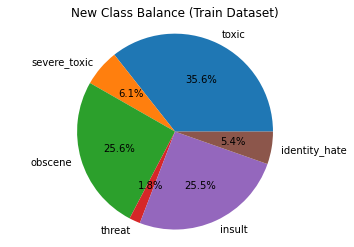

In [256]:
classes = {}

for index in range(1,7):
    classes.update({balanced_train.iloc[:,index].name : np.histogram(balanced_train.iloc[:,index], bins=2)[0]})

labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('New Class Balance (Train Dataset)')
plt.axis('equal')
plt.show()

#### Visualise the new class balance for test dataset

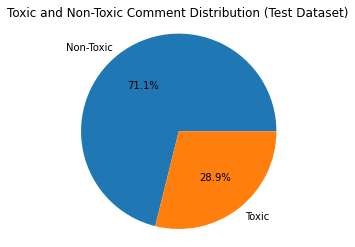

In [252]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = balanced_test[(balanced_test.toxic == 0) &
                  (balanced_test.severe_toxic == 0) & 
                  (balanced_test.obscene == 0) & 
                  (balanced_test.threat == 0) & 
                  (balanced_test.insult == 0) & 
                  (balanced_test.identity_hate == 0)]

# Gather all samples that are labelled
toxic = balanced_test[(balanced_test.toxic == 1) |
                  (balanced_test.severe_toxic == 1) | 
                  (balanced_test.obscene == 1) | 
                  (balanced_test.threat == 1) | 
                  (balanced_test.insult == 1) | 
                  (balanced_test.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution (Test Dataset)')
plt.axis('equal')
plt.show()

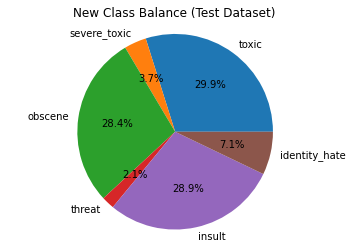

In [255]:
classes = {}

for index in range(1,7):
    classes.update({balanced_test.iloc[:,index].name : np.histogram(balanced_test.iloc[:,index], bins=2)[0]})

labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('New Class Balance (Test Dataset)')
plt.axis('equal')
plt.show()

#### Normalise and Clean Dataset

In [257]:
def clean_dataset(dataset):
    # Remove punctuation
    regex_str = "[^a-zA-Z\s]"
    dataset['comment_text'] = dataset['comment_text'].replace(regex=regex_str, value="")

    # Remove extra whitespaces
    regex_space = "\s+"
    dataset['comment_text'] = dataset['comment_text'].replace(regex=regex_space, value=" ")

    # Strip whitespaces
    dataset['comment_text'] = dataset['comment_text'].str.strip()

    # Lowercase
    dataset['comment_text'] = dataset['comment_text'].str.lower()

    # Convert comment_text column into a list
    comments_list = dataset['comment_text'].tolist()
    
    return comments_list


#### Lemmatize Dataset

In [258]:
def nltk_get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # Convert NOTK to wordnet POS notations
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

In [259]:
def lemmatize_dataset(comments):
    nltk.download('averaged_perceptron_tagger')
    comments_lemmatized = []
    lemmatizer = WordNetLemmatizer()
    lemmatizer_cache = lru_cache(maxsize=50000)(lemmatizer.lemmatize)

    for comment in comments:
        temp = []
        temp.append([lemmatizer_cache(word, pos=nltk_get_wordnet_pos(word)) for word in comment])
        comments_lemmatized += temp
        
    return comments_lemmatized

#### Remove Stopwords

In [260]:
def remove_stopwords(comments):
    # Remove stopwords, using stopword list from nltk
    removed_stopwords = []
    stopword_list = set(stopwords.words('english'))

    for comment in comments:
        removed_stopwords.append([word for word in comment if word not in stopword_list])
        
    return removed_stopwords

In [261]:
def pickle_dataset(filename, dataset):
    file = open("{0}.pickle".format(filename),"wb")
    pickle.dump(dataset, file)
    file.close()

#### Prepare Dataset

In [262]:
def prepare_dataset(dataset):
    comments_list = clean_dataset(dataset)
    comments = [sentence.split() for sentence in comments_list]
    comments_lemmatized = lemmatize_dataset(comments)
    preprocessed_dataset = remove_stopwords(comments_lemmatized)
    
    return preprocessed_dataset

In [264]:
#preprocessed_train = prepare_dataset(balanced_train)
preprocessed_test = prepare_dataset(balanced_test)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vinal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [265]:
#pickle_dataset("balanced_train", preprocessed_train)
pickle_dataset("balanced_test", preprocessed_test)

#### Visualise the top words for each label

In [181]:
def get_top_10_words(label):
    comment_list = balanced_train[(balanced_train[label] == 1)]["comment_text"].tolist()
    comments = [sentence.split() for sentence in comment_list]
    corpus = [word for sentence in comments for word in sentence]
    removed_stopwords = [word for word in corpus if word not in stopword_list]
    bow = Counter(removed_stopwords).most_common(25)
    df = pd.DataFrame(bow, columns = ['Word', 'Count'])
    df.plot.bar(x='Word',y='Count')

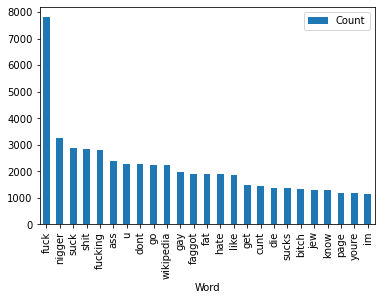

In [182]:
get_top_10_words("toxic")

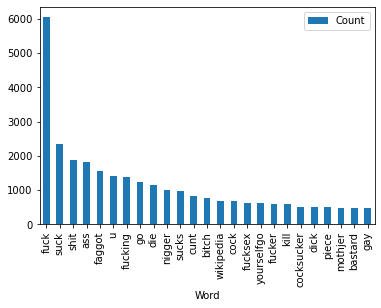

In [183]:
get_top_10_words("severe_toxic")

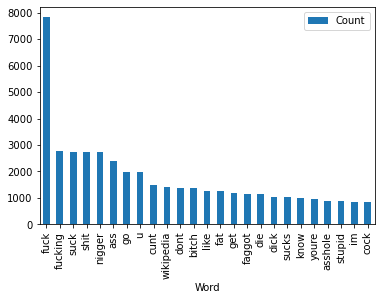

In [184]:
get_top_10_words("obscene")

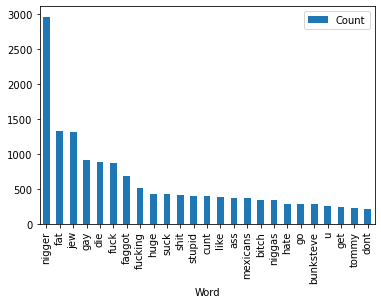

In [185]:
get_top_10_words("identity_hate")

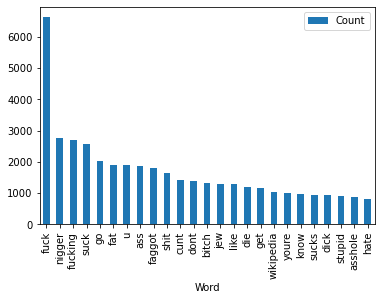

In [186]:
get_top_10_words("insult")

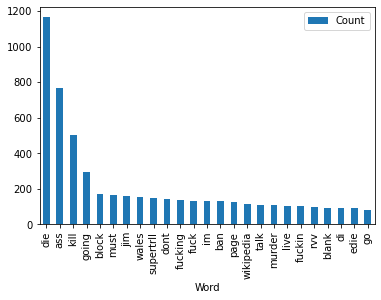

In [187]:
get_top_10_words("threat")

#### Tokenise Dataset

In [287]:
preprocessed_train = pickle.load(open("balanced_train.pickle", "rb"))
preprocessed_test = pickle.load(open("balanced_test.pickle", "rb"))

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(preprocessed_train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(preprocessed_train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

y_train = balanced_train[LABEL_FIELDS]
y_train = y_train.to_numpy()

x_sequences_test = tokenizer.texts_to_sequences(preprocessed_test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

y_test = balanced_test[LABEL_FIELDS]
y_test = y_test.to_numpy()

In [291]:
print(x_padded_train.shape)
print(y_train.shape)
print(x_padded_test.shape)
print(y_test.shape)

(78598, 150)
(78598, 6)
(10875, 150)
(10875, 6)


In [292]:
#pickle_dataset("balanced_train_labels", y_train)
pickle_dataset("balanced_test_labels", y_test)

# Base LSTM Model

In [201]:
def build_model(optimiser="adam"):
    model = Sequential()
    model.add(Embedding(len(corpus) + 1, 100, input_length=MAX_WORD))
    model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

    return model

In [202]:
model = build_model()

history = model.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
553/553 [==============================] - 326s 590ms/step - loss: 0.1863 - accuracy: 0.5562 - val_loss: 0.0512 - val_accuracy: 0.9952
Epoch 2/5
553/553 [==============================] - 342s 618ms/step - loss: 0.0814 - accuracy: 0.8994 - val_loss: 0.0476 - val_accuracy: 0.9952
Epoch 3/5
553/553 [==============================] - 344s 622ms/step - loss: 0.0709 - accuracy: 0.9603 - val_loss: 0.0478 - val_accuracy: 0.9952
Epoch 4/5
553/553 [==============================] - 341s 617ms/step - loss: 0.0645 - accuracy: 0.9794 - val_loss: 0.0486 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 325s 587ms/step - loss: 0.0607 - accuracy: 0.9830 - val_loss: 0.0509 - val_accuracy: 0.9952


In [203]:
model.save('baseline_model')

INFO:tensorflow:Assets written to: baseline_model\assets


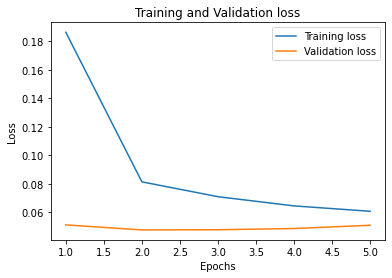

In [204]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

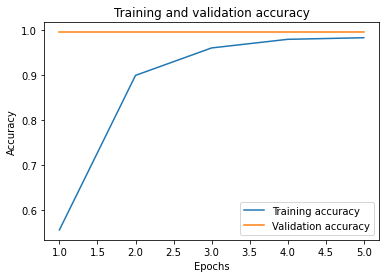

In [205]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [269]:
pred = model.predict(x_padded_test)

In [270]:
def round_pred(predictions):
    y_pred = [prediction.round() for prediction in predictions]
    
    return y_pred

In [271]:
def gen_confusion_matrix(y_true,y_pred):
    confusion_matrices={}

    for label_col in range(len(LABEL_FIELDS)):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]
        confusion_matrices[LABEL_FIELDS[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
    return confusion_matrices

In [272]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


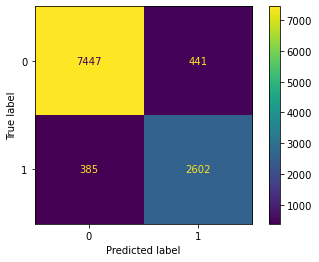

In [273]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


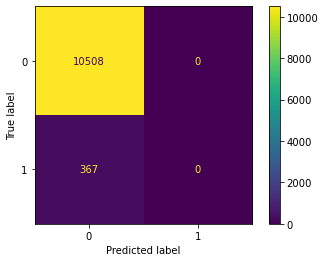

In [274]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


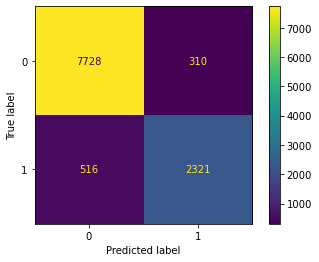

In [275]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


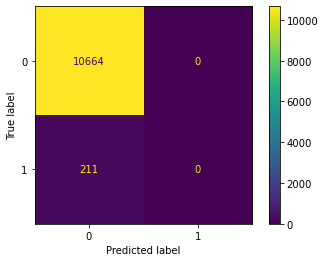

In [276]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


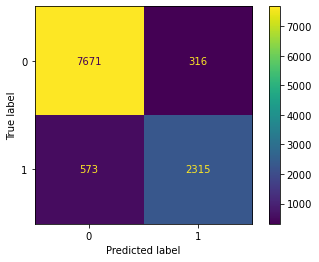

In [277]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


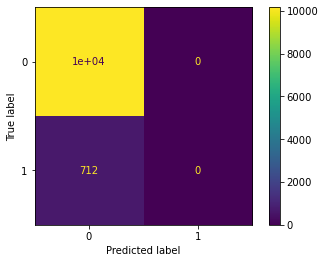

In [278]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

In [279]:
def plot_precision_recall_curve(y_test,y_pred):
    # precision recall curve
    precision = dict()
    recall = dict()

    for i in range(len(LABEL_FIELDS)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

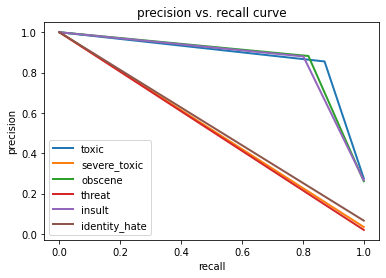

In [280]:
plot_precision_recall_curve(y_test,y_pred)

In [281]:
def plot_roc_curve(y_test, y_pred):
    # roc curve
    fpr = dict()
    tpr = dict()

    for i in range(len(LABEL_FIELDS)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                      y_pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()

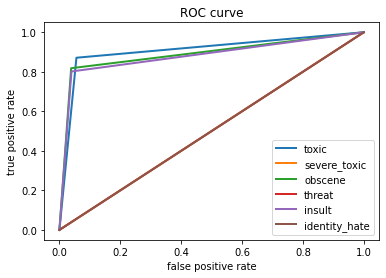

In [282]:
plot_roc_curve(y_test,y_pred)

In [283]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      2987
           1       0.00      0.00      0.00       367
           2       0.88      0.82      0.85      2837
           3       0.00      0.00      0.00       211
           4       0.88      0.80      0.84      2888
           5       0.00      0.00      0.00       712

   micro avg       0.87      0.72      0.79     10002
   macro avg       0.44      0.42      0.43     10002
weighted avg       0.76      0.72      0.74     10002
 samples avg       0.24      0.21      0.21     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Overall Evaluation
Overall the experiments have provided a good insight into how to optimise the LSTM model. The base LSTM already performs decently, having an average f1 score of 0.85 for the three labels with the most samples. The training history shows an accuracy of these models to hit above 90%, however, this is a misdirect as the dataset largely comprises of non-toxic comments (0s for all labels), which the model has generalised easily. The true indication of performance comes from viewing the precision, recall and f1 measures. All of the experiment setups struggled to predict whether a comment had the label "threat", "identity_hate" or "severe_toxic". The models were underfitted for those labels, as there is not enough samples in these categories for the model to generalise the data. This is supported by the class balance pie chart. A workaround this issue would be to use synonym replacement (text enrichment) to produce more samples for the 3 labels. This was an experiment setup of a member within my team, however, due to time contraints, I was unable to implement this within the data preparation. On the topic of data preparation, more analysis could have been done on the quality of samples, upon manually viewing the samples, there are many spelling mistakes, which prevents the model from detected the word. Given more time, a possible method to address these spelling mistakes is to use regular expression on the common misspelt words, which will increase the number of occurences of these key words.

To summarise, new insights were gained from the experiment setups that had positive impacts on the base LSTM model. The improvements are not as significant as originally intended, which could indicate that more adjustment is needed earlier in the pipline. It is evident from the data preparation visuals that the class imbalance has a strong impact on the setup results. These experimentations have only partially solved the original problem of detecting toxic comments; the model can effectively detect whether a comment is "toxic", "obscene" or an "insult", however, it could not generalise what makes a comment "severely toxic", a "threat" or "identity hate". 